# bioNER - DL Project Compling 2019

SOTA and latest advances: https://paperswithcode.com/sota/named-entity-recognition-ner-on-ontonotes-v5

In [0]:
import json
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import itertools

from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import torch
from torch.utils.data import Dataset, DataLoader

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

### Loading data

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = "steysie" # username from the json file 
os.environ['KAGGLE_KEY'] = "6469ce63000a8caf2a50989e9bb90b19" # key from the json file

In [3]:
!kaggle datasets download -d rsnayak/hackathon-disease-extraction-saving-lives-with-ai # api copied from kaggle

 96% 100M/104M [00:01<00:00, 99.5MB/s] 
100% 104M/104M [00:01<00:00, 101MB/s] 


In [4]:
!unzip hackathon-disease-extraction-saving-lives-with-ai.zip

Archive:  hackathon-disease-extraction-saving-lives-with-ai.zip
  inflating: Problem Statement - Disease Extraction.pdf  
  inflating: sample_submission_usrypCc/sample_submission.csv  
  inflating: sample_submission_usrypcc/sample_submission.csv  
  inflating: test_XEV14AD/test.csv   
  inflating: test_xev14ad/test.csv   
  inflating: train_3PIRKSI/train.csv  
  inflating: train_3pirksi/train.csv  


In [0]:
train = pd.read_csv("train_3pirksi/train.csv")
test = pd.read_csv("test_xev14ad/test.csv")

In [6]:
# 2994463
print(f"Train dataset length: {len(train)}")
print(f"Test dataset length: {len(test)}")
print(f"Test dataset is {len(test)/(len(test)+len(train))*100}% from total")

Train dataset length: 4543833
Test dataset length: 2994463
Test dataset is 39.723340659480606% from total


In [7]:
train[230:235]

,id,Doc_ID,Sent_ID,Word,tag
230,231,3,12,reproducibility,O
231,232,3,12,of,O
232,233,3,12,post-occlusive,O
233,234,3,12,reactive,B-indications
234,235,3,12,hyperemia,I-indications


In [8]:
test.head()

,id,Doc_ID,Sent_ID,Word
0,4543834,30001,191283,CCCVA
1,4543835,30001,191283,","
2,4543836,30001,191283,MANOVA
3,4543837,30001,191283,","
4,4543838,30001,191283,my


### Data preprocessing

Проверим, нет ли NaN в таблице. Если есть, нужно будет либбо заполнить их, либо исключить.

In [9]:
train.isnull().sum()

id           0
Doc_ID       0
Sent_ID      0
Word       130
tag          0
dtype: int64

Неопределенные значение есть, в колонке Word. Избавимся от них.

In [0]:
train = train.dropna(subset=['Word'])

In [11]:
train.isnull().sum()

id         0
Doc_ID     0
Sent_ID    0
Word       0
tag        0
dtype: int64

Посмотрим на теги - в них должны быть только три (BIO) тега.

In [12]:
train.groupby('tag').size().reset_index(name='counts')

,tag,counts
0,B-indications,53003
1,I-indications,44624
2,O,4446076


Lowercasing

In [0]:
train.Word = train.Word.str.lower()

In [14]:
train.head()

,id,Doc_ID,Sent_ID,Word,tag
0,1,1,1,obesity,O
1,2,1,1,in,O
2,3,1,1,low-,O
3,4,1,1,and,O
4,5,1,1,middle-income,O


In [0]:
corpus = list(train.Word)

### word2index

In [0]:
word2index = {'PAD':0}

for token in train.Word:
    if token not in word2index:
        word2index[token] = len(word2index)

In [17]:
len(word2index)

158164

In [0]:
# for OOV
word2index['UNK'] = len(word2index)

In [19]:
print(corpus[:5])

['obesity', 'in', 'low-', 'and', 'middle-income']


## [OBSOLETE] Word2vec Model Training

### Embeddings

In [0]:
class SkipgramDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 collect_verbose=True):
        
        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):
        
        # CODE  
        # вставить здесь функцию, которые вы писали раньше
    
        splits = []
            
        for i in range(len(tokenized_text)):
            center = tokenized_text[i]

            surrounding = tokenized_text[max(0, i-self.window):i] + tokenized_text[i+1:i+min(len(tokenized_text)-i, self.window+1)]
            splits.extend(list(itertools.product(surrounding, [center])))

        return splits

    def indexing(self, tokenized_text):

        #return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]
        return [self.word2index[tokenized_text] if token in self.word2index else self.unk_index]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            skipgram_examples = self._split_function(indexed_text)

            self.data.extend(skipgram_examples)

    def __getitem__(self, idx):
        
        # CODE
        
        context, central_word = self.data[idx]

        return context, central_word

In [0]:
dataset = SkipgramDataset(corpus, word2index)

100%|██████████| 4543703/4543703 [00:10<00:00, 418124.51it/s]


In [0]:
BATCH_SIZE = 512

In [0]:
len(dataset)

0

In [0]:
dataset_loader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)

ValueError: ignored

In [0]:
for x, y in dataset_loader:
    break

In [0]:
x[:3]

tensor([ 9596,  1268, 44659])

In [0]:
y[:3]

tensor([4710, 4710, 5780])

In [0]:
x.shape, y.shape

(torch.Size([512]), torch.Size([512]))

### Skipgram model training

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [0]:
class SkipGram(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()

        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim)
        
        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=True)

    def forward(self, x):
        
        x = self.in_embedding(x)  #.sum(dim=1)
        x = self.out_embedding(x) 

        return x

In [0]:
EMBEDDING_DIM = 128

In [0]:
model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM).to(device)

In [0]:
with torch.no_grad():
    pred = model(x.to(device))

pred.shape

torch.Size([512, 184506])

In [0]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

# aka loss function
criterion = torch.nn.CrossEntropyLoss().to(device)

In [0]:
epochs = 3

losses = []

for n_epoch in range(epochs):

    try:

        progress_bar = tqdm(total=len(dataset_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))

        for x, y in dataset_loader:

            x = x.to(device)
            y = y.to(device)

            pred = model(x)

            loss = criterion(pred, y)

            loss.backward()

            optimizer.step()

            current_loss_value = loss.item()
            losses.append(loss.item())
            
            progress_bar.set_postfix(loss=np.mean(losses[-100:]))

            progress_bar.update(x.shape[0])

        progress_bar.close()

    except KeyboardInterrupt:

        progress_bar.close()
        break

Epoch 1:  41%|████▏     | 27662848/66918222 [34:32<48:50, 13396.57it/s, loss=2.98]

Buffered data was truncated after reaching the output size limit.

In [0]:
# mount notebook to google drive, save the results

from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
ls: cannot access '/content/gdrive/My': No such file or directory
ls: cannot access 'Drive': No such file or directory


In [0]:
model_save_name = 'bio_skipgram.pt'
path = f"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)

In [0]:
!ls /content/gdrive/My Drive

ls: cannot access '/content/gdrive/My': No such file or directory
ls: cannot access 'Drive': No such file or directory


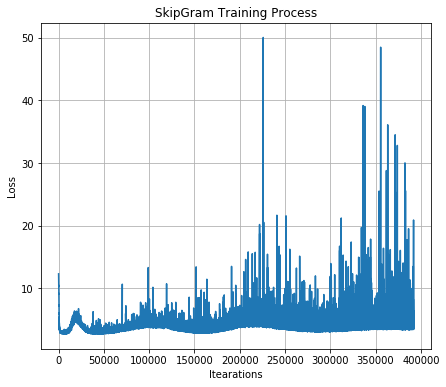

In [0]:
plt.figure(figsize=(7, 6))
plt.title('SkipGram Training Process')
plt.xlabel('Itearations')
plt.ylabel('Loss')
plt.grid()
plt.plot(losses)

In [0]:
embedding_matrix = model.in_embedding.weight.detach()

In [0]:
def cos_sim(embedding_matrix, token2id, word1, word2):
    
    i1 = token2id[word1]
    i2 = token2id[word2]
    
    v1, v2 = embedding_matrix[i1], embedding_matrix[i2]
    
    v1_n = v1.div(v1.norm(keepdim=True))
    v2_n = v2.div(v2.norm(keepdim=True))
    
    similarity = torch.dot(v1_n, v2_n).item()
    
    return similarity

In [0]:
cos_sim(embedding_matrix, word2index, 'disease', 'cancer')

0.01444193720817566

In [0]:
# split to train test

In [0]:
classes = np.unique(y)
classes = classes.tolist()

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=0)
X_train.shape, y_train.shape

((67000, 14956), (67000,))

### Wrapping in a DataLoader

In [0]:
from torch.utils.data import Dataset, DataLoader

## Pretrained embeddinds


Embeddings bio: https://github.com/ncbi-nlp/BioSentVec

Fasttext bio (26 GB): https://ftp.ncbi.nlm.nih.gov/pub/lu/Suppl/BioSentVec/BioWordVec_PubMed_MIMICIII_d200.bin

Fasttext bio (13 GB): https://ftp.ncbi.nlm.nih.gov/pub/lu/Suppl/BioSentVec/BioWordVec_PubMed_MIMICIII_d200.vec.bin


In [0]:
!wget https://ftp.ncbi.nlm.nih.gov/pub/lu/Suppl/BioSentVec/BioWordVec_PubMed_MIMICIII_d200.vec.bin

--2019-12-20 11:20:03--  https://ftp.ncbi.nlm.nih.gov/pub/lu/Suppl/BioSentVec/BioWordVec_PubMed_MIMICIII_d200.vec.bin
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.13, 2607:f220:41e:250::10
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13451441787 (13G) [application/octet-stream]
Saving to: ‘BioWordVec_PubMed_MIMICIII_d200.vec.bin’

BioWordVec_PubMed_M 100%[===================>]  12.53G  19.9MB/s    in 9m 56s  

2019-12-20 11:29:59 (21.5 MB/s) - ‘BioWordVec_PubMed_MIMICIII_d200.vec.bin’ saved [13451441787/13451441787]



In [0]:
from gensim.models.keyedvectors import KeyedVectors

In [0]:
model = KeyedVectors.load_word2vec_format('BioWordVec_PubMed_MIMICIII_d200.vec.bin', binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
len(model.wv.vocab)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


16545452

In [0]:
'day' in model.wv.vocab

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


True

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# word2index
vectors = []

embedding_dim = model.vector_size
n_words = len(model.wv.vocab)

# Zero vector for PAD
vectors.append(np.zeros((1, embedding_dim)))

# progress_bar = tqdm(desc='Read word2vec', total=n_words)

for i in word2index:
    if i in model.wv.vocab:
        vectors.append(model.wv[i])

    else:
        vectors.append(np.random.normal(scale=0.6, size=(embedding_dim, )))

#vectors = np.concatenate(vectors)
vectors = np.vstack(vectors)

np.save('/content/drive/My Drive/bioNER datasets/data.npy', vectors)

In [0]:
# Random vector for UNK
vectors.append(np.random.normal(scale=0.6, size=(embedding_dim, )))

In [0]:
np.save('/content/drive/My Drive/bioNER datasets/vectors_pad-unk.npy', vectors)

In [0]:
model.wv['obesity']

Замапим категории в индексы

In [0]:
cat_mapper = {cat: n for n, cat in enumerate(train.tag.unique())}

In [66]:
cat_mapper

{'B-indications': 1, 'I-indications': 2, 'O': 0}

In [0]:
train.tag = train.tag.map(cat_mapper)

In [0]:
train_sents = pd.read_csv('/content/drive/My Drive/bioNER datasets/sents/train_data_sentence-level_2019-12-19-07-41.csv').iloc[:, -2:]
test_sents = pd.read_csv('/content/drive/My Drive/bioNER datasets/sents/test_data_sentence-level_2019-12-19-07-41.csv').iloc[:, -2:]

In [0]:
import ast

In [0]:
train_sents.X_train = train_sents.X_train.apply(lambda x: ast.literal_eval(x)) #<- to convert string to list
train_sents.y_train = train_sents.y_train.apply(lambda x: ast.literal_eval(x))

In [0]:
test_sents.X_test = test_sents.X_test.apply(lambda x: ast.literal_eval(x))
test_sents.y_test = test_sents.y_test.apply(lambda x: ast.literal_eval(x))

In [0]:
test_sents.X_test.head().apply(type)

In [0]:
 X_train, X_test, y_train, y_test = train_sents.X_train, test_sents.X_test, train_sents.y_train, test_sents.y_test

In [0]:
class WordData(Dataset):
    
    def __init__(self, x_data, y_data, word2index, verbose=True):
        
        super().__init__()
        
        self.x_data = []
        self.y_data = y_data  
        self.word2index = word2index
        self.load(x_data, verbose=verbose)
        
    @staticmethod
    def process_text(text):
        words = [text]

        return words
        
    def load(self, data, verbose=True):
        
        data_iterator = tqdm(data, desc='Loading data', disable=not verbose)      
        
        for text in data_iterator:
            
            words = self.process_text(text)
            indexed_words = self.indexing(words)
            self.x_data.append(indexed_words)


    def indexing(self, tokenized_text):

        return [self.word2index[token] for token in tokenized_text if token in self.word2index]

    def __len__(self):
        
        return len(self.x_data)
    
    def __getitem__(self, idx):
        
        x = self.x_data[idx]
        x = torch.Tensor(x).long()    
        y = self.y_data[idx]

        return x, y

In [0]:
from sklearn.model_selection import train_test_split

In [71]:
train.Word[:5].tolist()

['obesity', 'in', 'low-', 'and', 'middle-income']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(train.Word[:int(len(train.Word)*0.7)], train.tag[:int(len(train.Word)*0.7)], test_size=0.1, shuffle=False)
# [:int(len(train.Word)*0.4)]

In [0]:
for instance in list(tqdm._instances):
    tqdm._decr_instances(instance)

In [87]:
train_dataset = WordData(X_train.tolist(), y_train.tolist(), word2index)
test_dataset = WordData(X_test.tolist(), y_test.tolist(), word2index)

train_loader = DataLoader(train_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

Loading data: 100%|██████████| 318060/318060 [00:00<00:00, 678703.71it/s]


In [0]:
for x, y in train_loader:
    break

In [0]:
#x

In [77]:
y

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

## LSTM model and training

In [0]:
vectors = np.load("/content/drive/My Drive/bioNER datasets/data.npy")

In [90]:
len(vectors)

158165

In [91]:
embs = torch.Tensor(vectors)

print(type(embs))
print(embs.shape)

<class 'torch.Tensor'>
torch.Size([158165, 200])


In [0]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

        self.embedding_layer = torch.nn.Embedding.from_pretrained(embs)

        self.LSTM = torch.nn.LSTM(input_size=200, hidden_size=128, bidirectional=True, batch_first=True)

        self.dropout = torch.nn.Dropout(p=0.2)

        # Dense Layers
        self.Linear1 = torch.nn.Linear(256, 64)
        self.Linear2 = torch.nn.Linear(64, 3)

    def forward(self, x):

        x = self.embedding_layer(x)
        #print(x.shape)
        x = self.dropout(x)   # <- the dropout layer fot LSTM input

        # RNN layer
        x, _ = self.LSTM(x)
        x = torch.nn.functional.relu(x)

        # x = self.dropout(x)
        # x = torch.nn.BatchNorm1d(x)   # crashes the whole notebook, so not gonna happen :(

        # Dense Layers
        x = torch.nn.functional.relu(self.Linear1(x[:, -1, :]))
        x = self.Linear2(x)

        # print(x.shape)
        # no softmax is needed (included in the loss, pytorch specific)

        return x

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

In [0]:
model = NeuralNetwork()  #.to(device)

In [0]:
criterion = torch.nn.CrossEntropyLoss()  #.to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [0]:
losses = []

for x, y in train_loader:

    # x = x.to(device)
    # y = y.to(device)
    #y = torch.Tensor(y)  
    
    optimizer.zero_grad()
    
    pred = model(x)

    pred_values, pred_indices = pred.max(1)
    # print(pred.shape)
    # print(y.shape)
    loss = criterion(pred, y)

    loss.backward()
    
    optimizer.step()

    #scheduler.step(loss)
    
    current_loss_value = loss.item()
    losses.append(loss.item())

### Full training

In [0]:
for instance in list(tqdm._instances):
    tqdm._decr_instances(instance)


In [0]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

In [97]:
epochs = 10
losses = []
# нужно для early stopping, то есть трекать лучший лосс на валидации
best_test_loss = 10.
accuracies = []
precisions = []
recalls = []
f1s = []

model_save_name = 'bi_lstm_200d_from-pretrained-embeddings_2019-12-20.pt'
path = f"/content/drive/My Drive/bioNER datasets/{model_save_name}" 

for n_epoch in range(epochs):
    
    train_losses = []
    test_losses = []
    test_preds = []
    test_targets = []
    
    progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))
    
    for x, y in train_loader:
        
        # x = x.to(device)
        # y = y.to(device)
        
        optimizer.zero_grad()
        
        pred = model(x)
        
        loss = criterion(pred, y)

        loss.backward()
        
        optimizer.step()
        
        train_losses.append(loss.item())
        losses.append(loss.item())
        
        progress_bar.set_postfix(train_loss = np.mean(losses[-500:]))

        progress_bar.update(x.shape[0])
        
    progress_bar.close()
    torch.save(model.state_dict(), path)
    
    for x, y in test_loader:
        
        # x = x.to(device)
        # y = y.to(device)

        with torch.no_grad():           
            pred = model(x)

        # pred.shape => (128, 5) => (batch_size, targets). Need to choose the *index* (!) with the largest value.
        pred_values, pred_indices = pred.max(1)

        # pred_cpu = pred_indices.cpu()
        # y_cpu = y.cpu()

        test_preds.append(pred_indices.numpy())
        test_targets.append(y.numpy())

        loss = criterion(pred, y)

        test_losses.append(loss.item())
        
    mean_test_loss = np.mean(test_losses)
        
    print('Losses: train = {:.3f}, test = {:.3f}'.format(np.mean(train_losses), mean_test_loss))
    
    test_preds = np.concatenate(test_preds)
    test_preds = test_preds.squeeze()
    test_targets = np.concatenate(test_targets).squeeze()
    
    accuracy = accuracy_score(test_targets, test_preds)
    precision = precision_score(test_targets, test_preds, average='macro')
    recall = recall_score(test_targets, test_preds, average='macro')
    f1 = f1_score(test_targets, test_preds, average='macro')

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

    print('Test: accuracy = {:.3f}'.format(accuracy))
    print('Test: precision = {:.3f}'.format(precision))
    print('Test: recall = {:.3f}'.format(recall))
    print('Test: f1_score = {:.3f}'.format(f1))
        
    # early stopping

    if mean_test_loss < best_test_loss:
        best_test_loss = mean_test_loss
    else:
        print('Early stopping')
        break    

Epoch 1: 100%|██████████| 2862532/2862532 [06:39<00:00, 7160.91it/s, train_loss=0.0693]


Losses: train = 0.072, test = 0.070


Epoch 2:   0%|          | 1024/2862532 [00:00<07:39, 6234.20it/s, train_loss=0.0686]

Test: accuracy = 0.981
Test: precision = 0.745
Test: recall = 0.495
Test: f1_score = 0.562


Epoch 2: 100%|██████████| 2862532/2862532 [06:37<00:00, 7196.92it/s, train_loss=0.0664]


Losses: train = 0.067, test = 0.068


Epoch 3:   0%|          | 1024/2862532 [00:00<08:24, 5667.97it/s, train_loss=0.0658]

Test: accuracy = 0.981
Test: precision = 0.755
Test: recall = 0.502
Test: f1_score = 0.570


Epoch 3: 100%|██████████| 2862532/2862532 [06:43<00:00, 7089.23it/s, train_loss=0.0638]


Losses: train = 0.064, test = 0.067


Epoch 4:   0%|          | 1152/2862532 [00:00<06:45, 7050.52it/s, train_loss=0.0632]

Test: accuracy = 0.981
Test: precision = 0.759
Test: recall = 0.502
Test: f1_score = 0.572


Epoch 4: 100%|██████████| 2862532/2862532 [06:49<00:00, 6985.49it/s, train_loss=0.0622]


Losses: train = 0.063, test = 0.066


Epoch 5:   0%|          | 1280/2862532 [00:00<06:41, 7124.76it/s, train_loss=0.0614]

Test: accuracy = 0.981
Test: precision = 0.756
Test: recall = 0.516
Test: f1_score = 0.585


Epoch 5: 100%|██████████| 2862532/2862532 [06:42<00:00, 7103.60it/s, train_loss=0.0608]


Losses: train = 0.061, test = 0.066


Epoch 6:   0%|          | 1024/2862532 [00:00<07:50, 6077.53it/s, train_loss=0.0602]

Test: accuracy = 0.981
Test: precision = 0.761
Test: recall = 0.508
Test: f1_score = 0.578


Epoch 6: 100%|██████████| 2862532/2862532 [06:49<00:00, 6993.10it/s, train_loss=0.0597]


Losses: train = 0.060, test = 0.065


Epoch 7:   0%|          | 1024/2862532 [00:00<07:48, 6106.75it/s, train_loss=0.0594]

Test: accuracy = 0.981
Test: precision = 0.758
Test: recall = 0.511
Test: f1_score = 0.582


Epoch 7: 100%|██████████| 2862532/2862532 [06:41<00:00, 7122.18it/s, train_loss=0.0588]


Losses: train = 0.059, test = 0.064


Epoch 8:   0%|          | 1024/2862532 [00:00<07:30, 6348.14it/s, train_loss=0.0585]

Test: accuracy = 0.981
Test: precision = 0.752
Test: recall = 0.515
Test: f1_score = 0.585


Epoch 8: 100%|██████████| 2862532/2862532 [06:43<00:00, 7102.58it/s, train_loss=0.0584]


Losses: train = 0.059, test = 0.064


Epoch 9:   0%|          | 896/2862532 [00:00<08:22, 5697.71it/s, train_loss=0.0582]

Test: accuracy = 0.982
Test: precision = 0.753
Test: recall = 0.512
Test: f1_score = 0.582


Epoch 9: 100%|██████████| 2862532/2862532 [06:45<00:00, 7066.67it/s, train_loss=0.0581]


Losses: train = 0.058, test = 0.064


Epoch 10:   0%|          | 1024/2862532 [00:00<07:49, 6088.45it/s, train_loss=0.0577]

Test: accuracy = 0.982
Test: precision = 0.756
Test: recall = 0.508
Test: f1_score = 0.579


Epoch 10: 100%|██████████| 2862532/2862532 [06:37<00:00, 7200.07it/s, train_loss=0.0578]


Losses: train = 0.058, test = 0.064
Test: accuracy = 0.982
Test: precision = 0.756
Test: recall = 0.520
Test: f1_score = 0.591
Early stopping


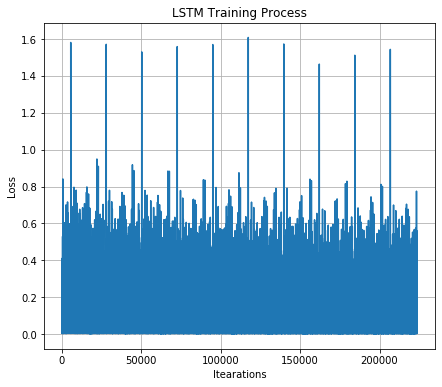

In [98]:
plt.figure(figsize=(7, 6))
plt.title('LSTM Training Process')
plt.xlabel('Itearations')
plt.ylabel('Loss')
plt.grid()
plt.plot(losses)

In [0]:
cm = confusion_matrix(test_preds, test_targets)

In [0]:
import seaborn as sn

In [0]:
categories = ['O', 'B-indications', 'I-indications'] # {'O': 0, 'B-indications': 1, 'I-indications': 2}

In [0]:
cm_normalized = cm / cm.astype(np.float).sum(axis=1)

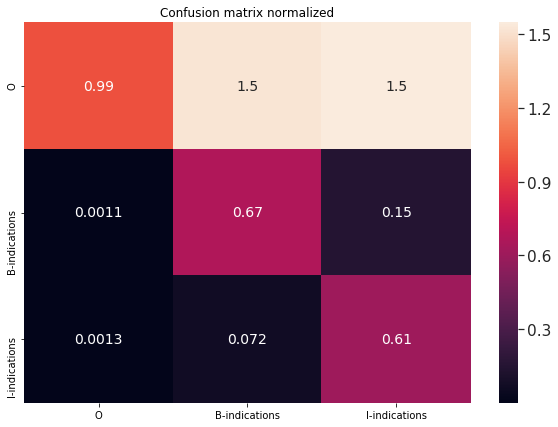

In [103]:
df_cm = pd.DataFrame(cm_normalized, categories, categories)
plt.figure(figsize = (10,7))
plt.title("Confusion matrix normalized")
sn.set(font_scale=1.4)   # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 14})  # font size

plt.show()

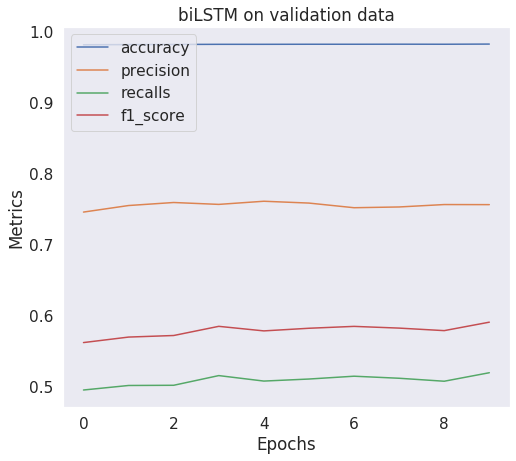

In [104]:
plt.figure(figsize=(8, 7))
plt.title('biLSTM on validation data')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.grid()

plt.plot(accuracies)
plt.plot(precisions)
plt.plot(recalls)
plt.plot(f1s)

plt.legend(['accuracy', 'precision', 'recalls', 'f1_score'], loc='upper left')

plt.show()